In [ ]:
"""
@Josh Boquiren
OTIS Lab MUSC
5.23.2023
"""

"""
Notes:
- this code relies on the existence of previously made .npy files; if no .npy files exist,
  please refer to one of the other programs where the preprocessing portion exists
"""

## Pilot

In [1]:
#import libraries

#data manipulation
import numpy as np
import pandas as pd

#plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#directory and file manager
import os

#statistics
import scipy.stats as stats
import scipy.io as sio
from sklearn.metrics import roc_auc_score as auROC
import statsmodels.api as sm
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples

from tqdm.notebook import tqdm

tqdm.pandas()


In [2]:
#initialize directories

population = 'ACQUISITION'

# user = 'jboqu'
user = 'OtisLab'

basedir = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data'%(user)

earlybasedir = os.path.join(basedir, 'EarlyAcq')
middlebasedir = os.path.join(basedir, 'MidAcq')
latebasedir = os.path.join(basedir, 'LateAcq')

models = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\universal_models'%(user)
results = r'C:\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\acquisition\results'%(user)

#cluster list files
early_newlabels = np.load(os.path.join(earlybasedir, 'cluster_list_per_session_Acquisition.npy')) #put clustering files in a folder to loop through
middle_newlabels = np.load(os.path.join(middlebasedir, 'cluster_list_per_session_Acquisition.npy'))
late_newlabels = np.load(os.path.join(latebasedir, 'cluster_list_per_session_Acquisition.npy'))

#for later plot titles
plot_titles = ['EARLY', 'MIDDLE', 'LATE']
population_title = "ACQ"

#animals of interest
early_animals_of_interest = [
    'CTL1',
    'ER-L2', 'ER-L1',
    'IG-19',
    'LCDD-PGa1','LCDD-PGa3','LCDD-PGa4','LCDD-PGa5','LCDD-PGa6',
    'LCDD-PGa-T1','LCDD-PGa-T2','LCDD-PGa-T3','LCDD-PGa-T4','LCDD-PGa-T5',
    'PGa-T1','PGa-T2','PGa-T3'
    ]  
middle_animals_of_interest = [
    'CTL1',

    'ER-L1', #FIXME - only 1 inactive press frame recorded
    'ER-L2',

    'IG-19',

    'LCDD-PGa1', #FIXME - only 1 inactive press frame recorded
    'LCDD-PGa3',
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6',

    'LCDD-PGa-T1',
    'LCDD-PGa-T2', #FIXME - only 1 inactive press frame recorded
    'LCDD-PGa-T3',
    'LCDD-PGa-T4',
    'LCDD-PGa-T5',

    'PGa-T1',
    'PGa-T2',
    'PGa-T3'
    ]  
late_animals_of_interest = [
    'CTL1',

    'ER-L1',
    'ER-L2',

    'IG-19',

    'LCDD-PGa1',
    'LCDD-PGa3', 
    'LCDD-PGa4',
    'LCDD-PGa5',
    'LCDD-PGa6',

    'LCDD-PGa-T1',
    'LCDD-PGa-T2',
    'LCDD-PGa-T3',
    'LCDD-PGa-T4',
    'LCDD-PGa-T5',

    'PGa-T1',
    'PGa-T2',
    'PGa-T3' #FIXME
    ]  

In [34]:
#frame rate variables
frameaveraging = 4
timebetweenframes = 33.3333
framerate = 30
framerate = timebetweenframes/frameaveraging #raw frame rate
averagedframerate = timebetweenframes/frameaveraging #averaged frame rate
print('Frame rate:', framerate)
print('Averaged frame rate:', averagedframerate)

#window size variables
pre_window_size = int(10*framerate) + 12
window_size =  int((pre_window_size*2)+(3*framerate))
post_window_size = window_size - pre_window_size
baselinefirstframe = 0
baselinelastframe = int(1*framerate)
infusionframe = int(pre_window_size+(3*framerate))
print('Prewindow size:', pre_window_size)
print('Window size:', window_size)
print('Postwindow size:', post_window_size)

#set cell tracking
tracking = 'No' ### 'Yes' or 'No'
sorting = 'Yes' ### 'Yes' or 'No'
sorttoearly = 'No' ###'Yes' or 'No'; This is for sorting, but align to early data. 'Sorting' must also be Yes
csv_id_for_tracking = 'CUE-DRUG-TMT'

#tracking
if tracking == 'Yes':
    population_active_tracked_early = np.nan*np.ones((1,window_size))
    population_active_tracked_middle = np.nan*np.ones((1,window_size))
    population_active_tracked_late = np.nan*np.ones((1,window_size))
    print ('Cell Tracking')
else:
    print ('No Cell Tracking')

Frame rate: 8.333325
Averaged frame rate: 8.333325
Prewindow size: 95
Window size: 214
Postwindow size: 119
No Cell Tracking


## Population Analysis

### Preprocessing

In [4]:
#method for fixing dropped frames
def fix_any_dropped_frames(frame_timestamps):
    first_frame = np.array([0])
    last_frame = np.array([int(np.max(frame_timestamps)+(500*timebetweenframes))])
    frame_index_temp = np.concatenate((first_frame,frame_timestamps, last_frame)) ###adds frame to timepoint '0' and an extra 500 frames at end
    frames_missed = [] ###creates empty list for us to add timestamps for missed frames
    for i in range(len(frame_index_temp)-1): ###iterates through each collected frame
            numframes_missed = int(np.round((frame_index_temp[i+1]-frame_index_temp[i])\
                /timebetweenframes)-1) ### number of missed frames per frame interval
            if numframes_missed > 0: 
                for j in range(numframes_missed):
                    frame_missed = np.array([frame_index_temp[i] + (int(timebetweenframes * (j+1)))])
                    frames_missed = np.concatenate((frames_missed, frame_missed))
    corrected_frame_index = np.array(sorted(np.concatenate((frame_index_temp, frames_missed))))
    return corrected_frame_index

#method for fixing assumed frames
def fix_assumed_frames(frames):
    dropped_frames = []
    diff_frames = np.diff(frames)
    inter_frame_interval = 33
    frame_drop_idx = np.where(diff_frames>1.5*inter_frame_interval)[0]
    for idx in frame_drop_idx:
        numframesdropped = int(np.round((frames[idx+1]-frames[idx])/(inter_frame_interval+0.0))-1)
        temp = [frames[idx]+a*inter_frame_interval for a in range(1,numframesdropped+1)]
        dropped_frames.extend(temp)
    corrected_frames = np.sort(np.concatenate((frames, np.array(dropped_frames))))
    return corrected_frames

#generate behavior data
try:
    assumed_frames = np.load(os.path.join(models, 'assumed_frames.npy'))
    assumed_frame_timestamps = np.load(os.path.join(models, 'assumed_frame_timestamps.npy'))
    print("Loaded behavior data.")
except:
    #load in data
    behaviordata_noframes = sio.loadmat(r"\Users\%s\Dropbox\2P Imaging Projects\Beth\Josh\Project Datasets\PFC Self-Admin Analysis\PFC Self Admin Data\Spreadsheets\matfile_noframes_3.mat"%(user))
    eventlog_noframes = np.squeeze(behaviordata_noframes['eventlog'])

    #parse desired data
    max_of_eventlog_noframes = max(eventlog_noframes[:,1]) #all rows, second column
    length_of_eventlog_noframes = len(eventlog_noframes[:,1])
    x = np.vstack((eventlog_noframes, eventlog_noframes, eventlog_noframes))
    x[length_of_eventlog_noframes:,1]= x[length_of_eventlog_noframes:,1]+max_of_eventlog_noframes
    x[length_of_eventlog_noframes*2:,1]= x[length_of_eventlog_noframes*2:,1]+(2*max_of_eventlog_noframes)
    eventlog_noframes = x

    assumed_frames = fix_any_dropped_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    assumed_frame_timestamps = fix_assumed_frames(eventlog_noframes[eventlog_noframes[:,0]==9,1]) ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO

    np.save(os.path.join(models, 'assumed_frames'), assumed_frames)
    np.save(os.path.join(models, 'assumed_frame_timestamps'), assumed_frame_timestamps)
    print("Behavior data processed and loaded.")


Loaded behavior data.


In [5]:
#various methods

def fit_regression(x, y):
    lm = sm.OLS(y, sm.add_constant(x)).fit()
    x_range = sm.add_constant(np.array([x.min(), x.max()]))
    x_range_pred = lm.predict(x_range)
    return lm.pvalues[1], lm.params[1], x_range[:,1], x_range_pred, lm.rsquared

def CDFplot(x, ax, color=None, label='', linetype='-'):
    x = np.array(x)
    ix=np.argsort(x)
    ax.plot(x[ix], ECDF(x)(x)[ix], linetype, color=color, label=label)
    return ax

def fit_regression_and_plot(x, y, ax, plot_label='', color='k', markersize=3):
    #linetype is a string like 'bo'
    pvalue, slope, temp, temppred, R2 = fit_regression(x, y)    
    ax.scatter(x, y, color=color, label='%s p=%.3f\nR$^2$=%.3f'% (plot_label, pvalue, R2), s=markersize)
    ax.plot(temp, temppred, color=color)
    return ax, slope, pvalue, R2

def ismembertol(x, y, tol=1E-6):
    # Are elements of x in y within tolerance of tol?
    # x and y must be 1d numpy arrays
    sortx = np.sort(x)
    orderofx = np.argsort(x)
    sorty = np.sort(y)
    current_y_idx = 0
    result = np.nan*np.zeros(x.shape)
    for i, elt in enumerate(sortx):
        temp = sorty[current_y_idx:]
        if np.any(np.abs(temp-elt)<=tol):
            result[orderofx[i]]=1
        else:
            result[orderofx[i]]=0
        temp = np.argwhere(sorty>elt)
        if temp.size>0:
            current_y_idx = temp[0][0]
    return result

def mkdir_p(path):
    #makes a new directory if it doesn't exist
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise 
            
def framenumberforevent(event, frame_timestamps):
    framenumber = np.nan*np.zeros(event.shape)
    for ie, e in enumerate(event):
        #print('     e:', e)
        if np.isnan(e):
            framenumber[ie] = np.nan
        else:
            temp = np.nonzero(frame_timestamps<=e)[0]
            if temp.shape[0]>0:
                framenumber[ie] = np.nonzero(frame_timestamps<=e)[0][-1]
            else:
                framenumber[ie] = 0
    return framenumber

def calculate_num_licks_for_each_frame(framenumberforlicks, numframes):
    numlicksperframe = np.nan*np.ones((numframes,))
    for i in range(numframes):
        numlicksperframe[i] = np.sum(framenumberforlicks==i)
    return numlicksperframe

def calculate_auROC(x,y,offset_to_zero=True):
    U, p = stats.mannwhitneyu(x,y)
    labels = np.concatenate((np.ones(x.shape), np.zeros(y.shape)))
    data = np.concatenate((x,y))
    A = auROC(labels, data)
    if offset_to_zero:
        return (2*(A-0.5), p)
    else:
        return (A, p)
    
def Benjamini_Hochberg_correction(vector_of_pvals,
                                  alpha = 0.05):
    # This function ipltements the BH FDR correction
    
    # Parameters:
    # Vector of p values from the different tests
    # alpha:significance level
    
    # Returns: Corrected p values. All the p values that are above the FDR threshold are set to 1. 
    #          Remaining p values are unchanged.
    
    sortedpvals = np.sort(vector_of_pvals)
    orderofpvals = np.argsort(vector_of_pvals)
    m = sortedpvals[np.isfinite(sortedpvals)].shape[0] #Total number of hypotheses
    for i in range(m):
        if sortedpvals[i] > (i+1)*alpha/m:
            k = i
            break
        elif i == m-1:
            k = m-1
        
    correctedpvals = np.copy(vector_of_pvals)
    correctedpvals[orderofpvals[k:]] = 1
    correctedpvals[np.isnan(vector_of_pvals)] = np.nan
    return correctedpvals

In [6]:
#method for animal analysis
def analyze_single_session(indir, window_size, pre_window_size):    
    tempfiles = next(os.walk(indir))[2]
    npyfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
        and 'extractedsignals_raw' in f]
    matfiles = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat']

    if len(npyfiles) > 1:
        npyfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' 
            and 'extractedsignals_raw' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        if npyfile[0][0]!='nan':
            npyfile = npyfile [0]
        matfile = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' 
            and not 'results' in f 
            and not 'part2' in f 
            and not 'part3' in f 
            and not 'part4' in f]
        matfile = matfile [0]
    else:
        npyfile = npyfiles[0]
        matfile = matfiles[0]
    
    signals = np.squeeze(np.load(os.path.join(indir, npyfile)))
    numneurons = signals.shape[0] 
   
    behaviordata = sio.loadmat(os.path.join(indir, matfile))
    eventlog = np.squeeze(behaviordata['eventlog'])
    licks = np.squeeze(behaviordata['licks'])
    lastframe_timestamp_part1 = np.max(eventlog)
    
    if len(npyfiles) > 1:
        npyfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part2' in f]
        matfiles2 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part2' in f and not 'results' in f]
        npyfile2 = npyfiles2[0]
        matfile2 = matfiles2[0]
        signals2 = np.squeeze(np.load(os.path.join(indir, npyfile2))) 
        if signals2[0][0]!='nan':
            signals = np.hstack((signals, signals2))
        behaviordata2 = sio.loadmat(os.path.join(indir, matfile2))
        eventlog2 = np.squeeze(behaviordata2['eventlog'])
        eventlog2[:,1] = eventlog2[:,1]+lastframe_timestamp_part1  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog2))
        lastframe_timestamp_part2 = np.max(eventlog)        
        licks2 = np.squeeze(behaviordata2['licks'])
        licks2 = licks2+lastframe_timestamp_part1
        licks = np.concatenate ([licks, licks2])
    if len(npyfiles) > 2:
        npyfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw'and 'part3' in f]
        matfiles3 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part3' in f and not 'results' in f]
        npyfile3 = npyfiles3[0]
        matfile3 = matfiles3[0]
        signals3 = np.squeeze(np.load(os.path.join(indir, npyfile3))) 
        if signals3[0][0]!='nan':
            signals = np.hstack((signals, signals3))
        behaviordata3 = sio.loadmat(os.path.join(indir, matfile3))
        eventlog3 = np.squeeze(behaviordata3['eventlog'])
        eventlog3[:,1] = eventlog3[:,1]+lastframe_timestamp_part2  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog3))
        lastframe_timestamp_part3 = np.max(eventlog)
        licks3 = np.squeeze(behaviordata3['licks'])
        licks3 = licks3+lastframe_timestamp_part2
        licks = np.concatenate ([licks, licks3])
    if len(npyfiles) > 3:
        npyfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.npy' and 'extractedsignals_raw' and 'part4' in f]
        matfiles4 = [f for f in tempfiles if os.path.splitext(f)[1]=='.mat' and 'part4' in f and not 'results' in f]
        npyfile4 = npyfiles4[0]
        matfile4 = matfiles4[0]
        signals4 = np.squeeze(np.load(os.path.join(indir, npyfile4))) 
        if signals4[0][0]!='nan':
            signals = np.hstack((signals, signals4))
        behaviordata4 = sio.loadmat(os.path.join(indir, matfile4))
        eventlog4 = np.squeeze(behaviordata4['eventlog'])
        eventlog4[:,1] = eventlog4[:,1]+lastframe_timestamp_part3  #adding the last frame to the second column of data in eventlog
        eventlog = np.concatenate((eventlog,eventlog4))
        lastframe_timestamp_part4 = np.max(eventlog)
        licks4 = np.squeeze(behaviordata4['licks'])
        licks4 = licks4+lastframe_timestamp_part3
        licks = np.concatenate ([licks, licks4])
    #pulling data from eventlog
    activelever = eventlog[eventlog[:,0]==22,1]
    activelevertimeout = eventlog[eventlog[:,0]==222,1]
    inactivelever = eventlog[eventlog[:,0]==21,1]
    inactivelevertimeout = eventlog[eventlog[:,0]==212,1]
    cues = eventlog[eventlog[:,0]==7,1]
    infusions = eventlog[eventlog[:,0]==4,1]    

    signals /= np.mean(signals, axis=1)[:, None]
    signalsT = signals.T
    
    ###IF YOUR CODE LACKS FRAME INPUTS, WE CAN ATTEMPT TO PREDICT FRAME TIMING BY USING PREVIOUS FRAME TIMESTAMPS
    if animal == 'CTL1' or animal == 'ER-L1' or animal == 'ER-L2' or animal == 'IG-19' or animal == 'IG-28' or animal == 'PGa-T1' or animal == 'XYZ':
        frame_timestamps = assumed_frame_timestamps ###Fixes issue for finding behavior IF YOU DON"T HAVE FRAME INFO
    else:
        frame_timestamps = fix_any_dropped_frames(eventlog[eventlog[:,0]==9,1]) 
    frame_timestamps = frame_timestamps[::frameaveraging] ###incorporates averaging into timestamp array
    
    ###DISCARDS BEHAVIORAL EVENTS THAT WERE NOT FULLY MONITORED WITH IMAGING
    if signals.shape[1] > frame_timestamps.shape[0]:
        signals = signals[:,:frame_timestamps.shape[0]-1] ###cuts signals so it's not longer than the frame timestamps
        
    final_frame_timestamp = frame_timestamps[signals.shape[1]] #This is the timestamp of the final frame in milliseconds
    #FIXME initialize flags here
    activelever = activelever[activelever<(final_frame_timestamp-(window_size/framerate*1000))]
    activelevertimeout = activelevertimeout[activelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelever = inactivelever[inactivelever<(final_frame_timestamp-(window_size/framerate*1000))]
    inactivelevertimeout = inactivelevertimeout[inactivelevertimeout<(final_frame_timestamp-(window_size/framerate*1000))]
    
    active_flags_dict = []
    for press in activelever:
        active_flags_dict.append({'Timestamp': press, 'Flag': 'cue'})
    for press in activelevertimeout:
        active_flags_dict.append({'Timestamp': press, 'Flag': 'no cue'})
    active_flags_df = pd.DataFrame(active_flags_dict)

    seconds_monitored = int(signals.shape[1]/averagedframerate) ###seconds monitored by 2p imaging
    seconds_behavior = int(max(activelever/1000)) ###final seconds to be monitored for behavior

    if seconds_monitored < seconds_behavior: #calculates last fully-monitored active lever press with 2p recording
        included_trials = []
        discarded_trials=[]
        for i in range(len(activelever)):
            if activelever[i]/1000<seconds_monitored:
                included_trials=np.append(included_trials, activelever[i])
            else:
                discarded_trials=np.append(discarded_trials,activelever[i]) #FIXME why is this even here?
        activelever=included_trials 
    #combines all presses
    activeleverall = np.hstack((activelever, activelevertimeout))
    inactiveleverall = np.hstack((inactivelever, inactivelevertimeout))

    #FIXME
    if activeleverall.shape[0] < 6:
        activeleverall =np.array([])
    if inactiveleverall.shape[0] < 6:
        inactiveleverall = np.array([])

    #method for calculating aligned data
    def calculate_aligneddata_forevent(data, frame_after_event): #FIXME
        framenumberfor_eventofinterest = np.squeeze(framenumberforevent(frame_after_event, frame_timestamps))
        numtrials = framenumberfor_eventofinterest.shape[0]
        if data.size==signals.size:
            align = np.NAN*np.zeros([numtrials,window_size,numneurons])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size,numneurons])###CHANGED ON AUGUST 20 2021
        else:
            align = np.NAN*np.zeros([numtrials,window_size])
            align_to_plot = np.NAN*np.zeros([numtrials,window_size])
        temp = data
        prevendindex = 0
        for i in range(numtrials):  ###CHANGED THIS SECTION ON AUGUST 20 2021
            tempindex = framenumberfor_eventofinterest[i]
            if np.isfinite(tempindex):
                tempindex = int(tempindex)
                tempstartindex = np.amin([pre_window_size, tempindex]).astype(int)
                startindex = np.amin([tempstartindex, tempindex-prevendindex]).astype(int)
                tempendindex = np.amin([len(frame_timestamps)-tempindex, post_window_size])
                if i<(numtrials-1) and np.isfinite(framenumberfor_eventofinterest[i+1]):
                    endindex = tempendindex
                else:
                    endindex = tempendindex
                    prevendindex = tempindex+endindex
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex,:] = temp[tempindex-startindex:tempindex+endindex,:]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex,:] = temp[tempindex-tempstartindex:tempindex+endindex,:]
                else: 
                    align_to_plot[i,pre_window_size-startindex:pre_window_size+endindex] = temp[tempindex-startindex:tempindex+endindex]
                    align[i,pre_window_size-tempstartindex:pre_window_size+endindex] = temp[tempindex-tempstartindex:tempindex+endindex]
            else:
                if temp.shape[0]!=temp.size:
                    align_to_plot[i,:,:] = np.nan*np.ones((window_size, numneurons))
                    align[i,:,:] = np.nan*np.ones((window_size, numneurons))
                else:
                    align_to_plot[i,:] = np.nan*np.ones((window_size))
                    align[i,:] = np.nan*np.ones((window_size))
        if temp.shape[0]!=temp.size:         
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]     
        else:
            align_to_plot = align_to_plot[np.where(np.isfinite(align_to_plot[:,0]))[0],:]
        return align, align_to_plot, framenumberfor_eventofinterest
    
    align_activelever, align_to_plot_activelever, framenumberfor_frameafter_activelever = \
        calculate_aligneddata_forevent(signalsT, activeleverall)  
    populationdata_activelever = np.nanmean(align_activelever, axis=0).T-1

    align_inactivelever, align_to_plot_inactivelever, framenumberfor_frameafter_inactivelever = \
        calculate_aligneddata_forevent(signalsT, inactiveleverall) #FIXME
    populationdata_inactivelever = np.nanmean(align_inactivelever, axis=0).T-1
    
    for i in range(signals.shape[0]):
        if np.isnan(np.mean(signals[i,:])):
            print(animal, fov, 'IMAGE J ROI.ZIP CELL NUMBER %s HAS NaNs AND SHOULD BE CHANGED'%(i+1))
        
    return populationdata_activelever, populationdata_inactivelever, align_activelever, align_inactivelever, framerate, active_flags_df

#### Making cue flag files

In [38]:
#Early population
excluded = []
for animal in early_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(earlybasedir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            activeLever, inactiveLever, alignedActiveLever, alignedInactiveLever, framerate, cueFlags = analyze_single_session(
                #analysis parameters
                os.path.join(earlybasedir, animal, fov), 
                window_size, 
                pre_window_size
                )
            cueFlags.to_csv(os.path.join(earlybasedir, animal, fov, 'active_flags.csv'), index=False)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('Early excluded animals:', excluded)

>>> CTL1
>>> ER-L2
>>> ER-L1


c:\Users\OtisLab\.conda\envs\josh\lib\site-packages\ipykernel_launcher.py:189: RuntimeWarning: Mean of empty slice


>>> IG-19
>>> LCDD-PGa1
>>> LCDD-PGa3
>>> LCDD-PGa4
>>> LCDD-PGa5
>>> LCDD-PGa6
>>> LCDD-PGa-T1
>>> LCDD-PGa-T2
>>> LCDD-PGa-T3
>>> LCDD-PGa-T4
>>> LCDD-PGa-T5
>>> PGa-T1
>>> PGa-T2
>>> PGa-T3
Early excluded animals: []


In [39]:
#Middle population
excluded = []
for animal in middle_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(middlebasedir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            activeLever, inactiveLever, alignedActiveLever, alignedInactiveLever, framerate, cueFlags = analyze_single_session(
                #analysis parameters
                os.path.join(middlebasedir, animal, fov), 
                window_size, 
                pre_window_size
                )
            cueFlags.to_csv(os.path.join(middlebasedir, animal, fov, 'active_flags.csv'), index=False)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('Middle excluded animals:', excluded)

>>> CTL1
>>> ER-L1


c:\Users\OtisLab\.conda\envs\josh\lib\site-packages\ipykernel_launcher.py:189: RuntimeWarning: Mean of empty slice


>>> ER-L2
>>> IG-19
>>> LCDD-PGa1
>>> LCDD-PGa3
>>> LCDD-PGa4
>>> LCDD-PGa5
>>> LCDD-PGa6
>>> LCDD-PGa-T1
>>> LCDD-PGa-T2
>>> LCDD-PGa-T3
>>> LCDD-PGa-T4
>>> LCDD-PGa-T5
>>> PGa-T1
>>> PGa-T2
>>> PGa-T3
Middle excluded animals: []


In [40]:
#Late population
excluded = []
for animal in late_animals_of_interest:
    print('>>>', animal)
    FOVs = next(os.walk(os.path.join(latebasedir, animal)))[1]
    for fov in sorted(FOVs):
        try:
            activeLever, inactiveLever, alignedActiveLever, alignedInactiveLever, framerate, cueFlags = analyze_single_session(
                #analysis parameters
                os.path.join(latebasedir, animal, fov), 
                window_size, 
                pre_window_size
                )
            cueFlags.to_csv(os.path.join(latebasedir, animal, fov, 'active_flags.csv'), index=False)
        except Exception as e:
            print('***ERROR:', e, '***')
            excluded.append(animal)
print('Late excluded animals:', excluded)

>>> CTL1


c:\Users\OtisLab\.conda\envs\josh\lib\site-packages\ipykernel_launcher.py:189: RuntimeWarning: Mean of empty slice


>>> ER-L1
>>> ER-L2
>>> IG-19
>>> LCDD-PGa1
>>> LCDD-PGa3
>>> LCDD-PGa4
>>> LCDD-PGa5
>>> LCDD-PGa6
>>> LCDD-PGa-T1
>>> LCDD-PGa-T2
>>> LCDD-PGa-T3
>>> LCDD-PGa-T4
>>> LCDD-PGa-T5
>>> PGa-T1
>>> PGa-T2
>>> PGa-T3
Late excluded animals: []


In [41]:
#making population dataframes

groups = ['Early', 'Middle', 'Late']
animals = [early_animals_of_interest, middle_animals_of_interest, late_animals_of_interest]
directories = [earlybasedir, middlebasedir, latebasedir]

temp_dict = [] #list for population array
for index in range(len(groups)):
    group = groups[index]
    animals_of_interest = animals[index]
    indir = directories[index]
    for animal in animals_of_interest:
        FOVs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(FOVs):
            flags = pd.read_csv(os.path.join(indir, animal, fov, 'active_flags.csv'))
            for i in range(len(flags)):
                # print(flags['Timestamp'][i], '-', flags['Flag'][i])
                temp_dict.append(
                    {'Group': group,
                     'Animal': animal,
                     'Timestamp': flags['Timestamp'][i],
                     'Flag': flags['Flag'][i]}
                )
flags_df = pd.DataFrame(temp_dict)
#flags_df[flags_df['Flag']=='cue'][flags_df['Group']=='Late'].head(20) #ex how to reference in dataframe
flags_df.head(20)


,Group,Animal,Timestamp,Flag
0,Early,CTL1,362926,cue
1,Early,CTL1,854689,cue
2,Early,CTL1,1882559,cue
3,Early,CTL1,3221116,cue
4,Early,CTL1,3279653,cue
5,Early,CTL1,6105130,cue
6,Early,CTL1,7385406,cue
7,Early,CTL1,7930088,cue
8,Early,CTL1,8209172,cue
9,Early,CTL1,9065859,cue


### Stacking data

#### All population data

In [17]:
#overload method
def stack_data1(indir, animals_of_interest, window, signals_file):
    temp_data = np.nan*np.ones((1, window))
    for animal in animals_of_interest:
            FOVs = next(os.walk(os.path.join(indir, animal)))[1]
            for fov in sorted(FOVs):
                    try:
                        #load in data
                        signal_data = np.load(os.path.join(indir, animal, fov, signals_file))
                        #stack data
                        temp_data = np.vstack((temp_data, signal_data))
                    except Exception as e:
                        print('***ERROR:', e, ' ***')
    data = temp_data[1:,:]
    return(data)
    
#method for stacking data
def stack_data2(indir, animals_of_interest, window, signals_file, aligned_levers_file):
    temp_data = np.nan*np.ones((1, window))
    for animal in animals_of_interest:
            FOVs = next(os.walk(os.path.join(indir, animal)))[1]
            for fov in sorted(FOVs):
                    try:
                        #load in data
                        signal_data = np.load(os.path.join(indir, animal, fov, signals_file))
                        lever_data = np.load(os.path.join(indir, animal, fov, aligned_levers_file))
                        #stack data
                        temp_data = np.vstack((temp_data, signal_data))
                    except Exception as e:
                        print('***ERROR:', e, ' ***')
    data = temp_data[1:,:]
    return(data, lever_data)

In [10]:
#method for matching neurons to clusters based on criteria
def find_indexes(indir, sub_animals_of_interest_array, original_full_stack, signal_file, cluster_labels_file):
    indexes = []
    for animal in sub_animals_of_interest_array:
        FOVs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(FOVs):
            signal_data = np.load(os.path.join(indir, animal, fov, signal_file))
            for neuron in range(len(signal_data)):
                for row in range(len(original_full_stack)):
                    if np.equal(signal_data[neuron], original_full_stack[row])[0]==True:
                        indexes.append({'Animal': animal, 'Stack index': row, 'Cluster': cluster_labels_file[row]})
    indexes = pd.DataFrame(indexes)
    return(indexes)

In [46]:
#stacking early data

#early active data
temp_early_active = stack_data1(earlybasedir, early_animals_of_interest, 190, "active.npy")

#num neurons
numneurons_early_active = temp_early_active.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_early_active[:,baselinefirstframe:baselinelastframe], axis=1)
early_active = temp_early_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_active[:,pre_window_size-(1*int(framerate)):pre_window_size+(1*int(framerate))], axis=1)
sortresponse_early_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
early_active_mean = np.nanmean(early_active, axis=0)


#early inactive data
temp_early_inactive = stack_data1(earlybasedir, early_animals_of_interest, 190, "inactive.npy")

#num neurons
numneurons_early_inactive = temp_early_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_early_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
early_inactive = temp_early_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(early_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_early_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
early_inactive_mean = np.nanmean(early_inactive, axis=0)

print('Active shape:', early_active.shape)
print('Inative shape:', early_inactive.shape)


Active shape: (2392, 190)
Inative shape: (2392, 190)


c:\Users\OtisLab\.conda\envs\josh\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


In [47]:
#stacking middle data

#middle active data
temp_middle_active = stack_data1(middlebasedir, middle_animals_of_interest, 190, "active.npy")

#num neurons is length of data
numneurons_middle_active = temp_middle_active.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_middle_active[:,baselinefirstframe:baselinelastframe], axis=1)
middle_active = temp_middle_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
middle_active_mean = np.nanmean(middle_active, axis=0)


#middle inactive data
temp_middle_inactive = stack_data1(middlebasedir, middle_animals_of_interest, 190, "inactive.npy")

#num neurons is length of data
numneurons_middle_inactive = temp_middle_inactive.shape[0]

#calculating population data - baseline
baseline = np.mean(temp_middle_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
middle_inactive = temp_middle_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(middle_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_middle_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
middle_inactive_mean = np.nanmean(middle_inactive, axis=0)

print('Active shape:', middle_active.shape)
print('Inative shape:', middle_inactive.shape)


Active shape: (2592, 190)
Inative shape: (2592, 190)


c:\Users\OtisLab\.conda\envs\josh\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


In [48]:
#stacking late data

#late active data
temp_late_active = stack_data1(latebasedir, late_animals_of_interest, 190, "active.npy")

#num neurons is length of data
numneurons_late_active = temp_late_active.shape[0]-1 

#calculating population data - baseline
baseline = np.mean(temp_late_active[:,baselinefirstframe:baselinelastframe], axis=1)
late_active = temp_late_active - baseline[:,None]

#sorting data
tempresponse = np.nanmean(late_active[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_late_active = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
late_active_mean = np.nanmean(late_active, axis=0)


#late inactive data
temp_late_inactive = stack_data1(latebasedir, late_animals_of_interest, 190, "inactive.npy")

#num neurons is length of data
numneurons_late_inactive = temp_late_inactive.shape[0]-1 

#calculating population data - baseline
baseline = np.mean(temp_late_inactive[:,baselinefirstframe:baselinelastframe], axis=1)
late_inactive = temp_late_inactive - baseline[:,None]

#sorting data
tempresponse = np.nanmean(late_inactive[:,pre_window_size-(1*int(framerate)):pre_window_size+1*int(framerate)], axis=1)
sortresponse_late_inactive = np.argsort(tempresponse)[::-1]

#calculating the mean using pandas
late_inactive_mean = np.nanmean(late_inactive, axis=0)

print('Active shape:', late_active.shape)
print('Inative shape:', late_inactive.shape)

Active shape: (2237, 190)
Inative shape: (2237, 190)


c:\Users\OtisLab\.conda\envs\josh\lib\site-packages\ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice


### Plots

In [27]:
#filter out the NaN values
def filter_NAN(processed_data, windowsize, prewindowsize, framerate):
        filtered_stack = np.nan*np.ones((1, windowsize))
        for row in processed_data:
                if np.isfinite(row[0]):
                        filtered_stack = np.vstack((filtered_stack, row))
        filtered_stack = filtered_stack[1:,:]
        response = np.nanmean(filtered_stack[:,prewindowsize-(1*int(framerate)):prewindowsize+1*int(framerate)], axis=1)
        sortresponse = np.argsort(response)[::-1]
        return(filtered_stack, sortresponse)

c:\Users\OtisLab\.conda\envs\josh\lib\site-packages\ipykernel_launcher.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.


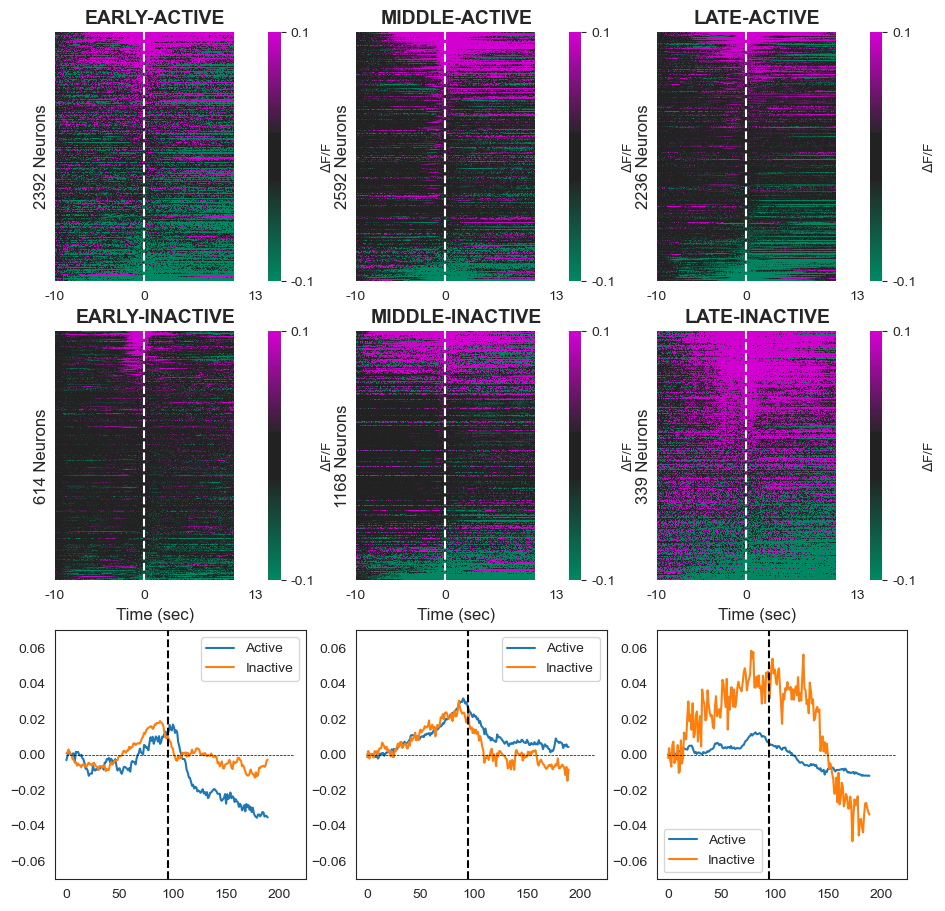

In [50]:
#plot

# initialize the plot
# 2 rows and 3 columns of graphs; may end up with blank column
fig, axs = plt.subplots(3, 3, figsize=(11, 11))
sns.set_style('white')

# setting max/min variables
cmax = .1
cmin = -cmax
ymax = .1
ymin = -ymax

# early active plots
ax = axs[0, 0]

# heatmap
hm = sns.heatmap(early_active[sortresponse_early_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1]) #<-- set tick index
ax.set(xticklabels=["-10", "0", "13"]) #<-- set tick labels

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_early_active, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_active], '--k', linewidth=1.5, color='white') #leverpress line <-- change line color

# line plot
ax = axs[2, 0]
ax.plot(early_active_mean)
ax.plot(early_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Active', 'Inactive'])

# early inactive plots (sorted to active plot)
ax = axs[1, 0]

#filtering NaN's
sorted_sub_early_inactive, inactive_sort = filter_NAN(early_inactive, 190, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_sub_early_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[0]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_sub_early_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_early_inactive], '--', linewidth=1.5, color='white')

# middle active plots
ax = axs[0, 1]

# heatmap
hm = sns.heatmap(middle_active[sortresponse_middle_active, :], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_middle_active, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[2, 1]
ax.plot(middle_active_mean)
ax.plot(middle_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Active', 'Inactive'])

# middle inactive plots
ax = axs[1, 1]

#filtering NaN's
sorted_sub_middle_inactive, inactive_sort = filter_NAN(middle_inactive, 190, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_sub_middle_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[1]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_sub_middle_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_middle_inactive], '--', linewidth=1.5, color='white')

# late active plots
ax = axs[0, 2]

# heatmap
hm = sns.heatmap(late_active[sortresponse_late_active,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# color bar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0","13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-ACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % numneurons_late_active, fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_active], '--', linewidth=1.5, color='white')

# line plot
ax = axs[2, 2]
ax.plot(late_active_mean)
ax.plot(late_inactive_mean)
ax.set_ylim([-.07, .07])
ax.plot([0, window_size], [0, 0], '--k', linewidth=0.5)
ax.axvline(pre_window_size, color='black', linestyle='--')
ax.legend(['Active', 'Inactive'])

# late inactive plots
ax = axs[1, 2]

#filtering NaN's
sorted_sub_late_inactive, inactive_sort = filter_NAN(late_inactive, 190, pre_window_size, framerate)

# heatmap
hm = sns.heatmap(sorted_sub_late_inactive[inactive_sort,:], ax=ax, vmax=cmax, vmin=cmin, linewidth=0,
                 cmap=sns.diverging_palette(
                     154, 308, n=230, s=100, sep=50, center='dark'),
                 cbar_kws={'label': '$\Delta$F/F'}, xticklabels=False,  yticklabels=False)  # sets tick label increments

# colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([-.1, .1])
cbar.set_ticklabels([cmin, cmax])
ax.set(xticks=[0, pre_window_size, window_size-1])
ax.set(xticklabels=["-10", "0", "13"])

#lines and labels
ax.grid(False)
ax.set_title(plot_titles[2]+"-INACTIVE", fontweight="bold", fontsize=14)
ax.set_ylabel('%s Neurons' % sorted_sub_late_inactive.shape[0], fontsize=12)
ax.set_xlabel('Time (sec)', fontsize=12)
ax.plot([pre_window_size, pre_window_size],
        [0, numneurons_late_inactive], '--', linewidth=1.5, color='white')


In [ ]:
# #save fig
# fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-inactive-all_population_heatmaps.PDF'), format='PDF')
# fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-inactive-all_population_heatmaps.PNG'), format='PNG')

## Cluster Analysis

In [ ]:
#import libraries

import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
from sklearn.manifold import TSNE
from scipy import interpolate
import statsmodels.formula.api as smf
from patsy import (ModelDesc, EvalEnvironment, Term, EvalFactor, LookupFactor, dmatrices, INTERCEPT)

import matplotlib.pyplot as plt

### Plotting clusters

#### All population data

In [ ]:
#inactive data
early_populationdata = early_inactive
middle_populationdata = middle_inactive
late_populationdata = late_inactive
all_populationdata = np.vstack((early_inactive, middle_inactive, late_inactive))

##active data
#early_populationdata = early_active
#middle_populationdata = middle_active
#late_populationdata = late_active
#all_populationdata = np.vstack((early_active, middle_active, late_active))

#num neurons
early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]

print('Early population num neurons:', early_numneurons)
print('Middle population num neurons:', middle_numneurons)
print('Late population num neurons:', late_numneurons)
print('All population num neurons:', all_numneurons)
print()

#cluster list files
all_newlabels = np.hstack((early_newlabels, middle_newlabels, late_newlabels))

#the label values should match the num of neurons
print('Early labels shape:', early_newlabels.shape)
print('Middle labels shape:', middle_newlabels.shape)
print('Late labels shape:', late_newlabels.shape)
print('All labels shape:', all_newlabels.shape)



In [ ]:
#cluster heatmaps

sessions = ['early', 'middle', 'late', 'all'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for cluster, cluster in enumerate(uniquelabels):
    sortwindow[cluster] = {}
    if cluster == 0:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 1:
        sortwindow[cluster] = [infusionframe+int(1*framerate), -1]
    if cluster == 2:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 3:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[cluster] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
        hm = sns.heatmap(
                    temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



In [ ]:
#save fig
#fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-all_clusters_heatmaps.PDF'), format='PDF')
#fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-all_clusters_heatmaps.PNG'), format='PNG')

fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_inactive-all_clusters_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_inactive-all_clsters_heatmaps.PNG'), format='PNG')

In [ ]:
#cluster line plots

fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for cluster, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            temp = early_populationdata[np.where(early_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:] #FIXME
        elif session == 'middle':
            temp = middle_populationdata[np.where(middle_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:] #FIXME
        elif session == 'late':
            temp = late_populationdata[np.where(late_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:] #FIXME
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:] #FIXME
        numneuronsincluster[cluster] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, cluster])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.2, .2))
        axs[s, cluster].text(x = s, y = .1, s = 'n = %d'%(numneuronsincluster[cluster]))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


In [ ]:
#save fig
#fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-all_clusters_polylines.PDF'), format='PDF')
#fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_active-all_clusters_polylines.PNG'), format='PNG')

fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_inactive-all_clusters_polylines.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'PFC_HEROIN_SA_Acquisition_inactive-all_clusters_polylines.PNG'), format='PNG')

#### Population data based on lever presses

##### Active clustering

In [ ]:
#active data
early_populationdata = early_active
middle_populationdata = middle_active
late_populationdata = late_active
all_populationdata = np.vstack((early_active, middle_active, late_active))

#num neurons
early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]

print('Early population num neurons:', early_numneurons)
print('Middle population num neurons:', middle_numneurons)
print('Late population num neurons:', late_numneurons)
print('All population num neurons:', all_numneurons)
print()

#cluster list files
all_newlabels = np.hstack((early_newlabels, middle_newlabels, late_newlabels))

#the label values should match the num of neurons
print('Early labels shape:', early_newlabels.shape)
print('Middle labels shape:', middle_newlabels.shape)
print('Late labels shape:', late_newlabels.shape)
print('All labels shape:', all_newlabels.shape)



In [ ]:
#cluster heatmaps

sessions = ['early', 'middle', 'late'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for cluster, cluster in enumerate(uniquelabels):
    sortwindow[cluster] = {}
    if cluster == 0:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 1:
        sortwindow[cluster] = [infusionframe+int(1*framerate), -1]
    if cluster == 2:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 3:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            df_reference = sub_early_active_df['Stack index'][np.where(sub_early_active_df['Cluster']==cluster)[0]]
            temp = early_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            df_reference = sub_middle_active_df['Stack index'][np.where(sub_middle_active_df['Cluster']==cluster)[0]]
            temp = middle_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            df_reference = sub_late_active_df['Stack index'][np.where(sub_late_active_df['Cluster']==cluster)[0]]
            temp = late_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[cluster] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
        hm = sns.heatmap(
                    temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



In [ ]:
#save fig
fig.savefig(os.path.join(results, 'clusters', 'subset_6_presses', 'PFC_HEROIN_SA_Acquisition_active-subset_clusters_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'clusters', 'subset_6_presses', 'PFC_HEROIN_SA_Acquisition_active-subset_clusters_heatmaps.PNG'), format='PNG')

In [ ]:
#cluster line plots

fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for cluster, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            df_reference = sub_early_active_df['Stack index'][np.where(sub_early_active_df['Cluster']==cluster)[0]]
            temp = early_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            df_reference = sub_middle_active_df['Stack index'][np.where(sub_middle_active_df['Cluster']==cluster)[0]]
            temp = middle_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            df_reference = sub_late_active_df['Stack index'][np.where(sub_late_active_df['Cluster']==cluster)[0]]
            temp = late_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[cluster] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, cluster])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.2, .2))
        axs[s, cluster].text(x = s, y = .1, s = 'n = %d'%(numneuronsincluster[cluster]))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


In [ ]:
#save fig
fig.savefig(os.path.join(results, 'clusters', 'subset_6_presses', 'PFC_HEROIN_SA_Acquisition_active-subset_clusters_polylines.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'clusters', 'subset_6_presses', 'PFC_HEROIN_SA_Acquisition_active-subset_clusters_polylines.PNG'), format='PNG')

##### Inactive clustering

In [ ]:
#inactive data
early_populationdata = early_inactive
middle_populationdata = middle_inactive
late_populationdata = late_inactive
all_populationdata = np.vstack((early_inactive, middle_inactive, late_inactive))

#num neurons
early_numneurons = early_populationdata.shape[0]
middle_numneurons = middle_populationdata.shape[0]
late_numneurons = late_populationdata.shape[0]
all_numneurons = all_populationdata.shape[0]

print('Early population num neurons:', early_numneurons)
print('Middle population num neurons:', middle_numneurons)
print('Late population num neurons:', late_numneurons)
print('All population num neurons:', all_numneurons)
print()

#cluster list files
all_newlabels = np.hstack((early_newlabels, middle_newlabels, late_newlabels))

#the label values should match the num of neurons
print('Early labels shape:', early_newlabels.shape)
print('Middle labels shape:', middle_newlabels.shape)
print('Late labels shape:', late_newlabels.shape)
print('All labels shape:', all_newlabels.shape)



In [ ]:
#cluster heatmaps

sessions = ['early', 'middle', 'late'] ###SET TO THE DIFFERENT TIME POINTS THAT WERE USED FOR TRACKING
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)

sortwindow = {}
for cluster, cluster in enumerate(uniquelabels):
    sortwindow[cluster] = {}
    if cluster == 0:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 1:
        sortwindow[cluster] = [infusionframe+int(1*framerate), -1]
    if cluster == 2:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    if cluster == 3:
        sortwindow[cluster] = [pre_window_size, infusionframe+int(3*framerate)]
    
cmax = 0.1

fig, axs = plt.subplots(len(sessions),len(uniquelabels),
                        figsize=(2*len(uniquelabels),2*len(sessions)))
cbar_ax = fig.add_axes([.94, .3, .01, .4])
cbar_ax.tick_params(width=0.5) 

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

for cluster, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            df_reference = sub_early_inactive_df['Stack index'][np.where(sub_early_inactive_df['Cluster']==cluster)[0]]
            temp = early_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            df_reference = sub_middle_inactive_df['Stack index'][np.where(sub_middle_inactive_df['Cluster']==cluster)[0]]
            temp = middle_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            df_reference = sub_late_inactive_df['Stack index'][np.where(sub_late_inactive_df['Cluster']==cluster)[0]]
            temp = late_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[cluster] = temp.shape[0]
        sortresponse = np.argsort(np.mean(temp[:,sortwindow[cluster][0]:sortwindow[cluster][1]], axis=1))[::-1]
        hm = sns.heatmap(
                    temp[sortresponse],
                    ax=axs[s, cluster],
                    cmap=sns.diverging_palette(154, 308,n=230,s=100,sep=50,center='dark'),
                    vmin=-cmax,
                    vmax=cmax,
                    cbar=(cluster==0),
                    cbar_ax=cbar_ax if (cluster==0) else None,
                    cbar_kws={'label': 'Normalized fluorescence', 'ticks': [cmax, cmin]}
                    )
        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_xticklabels([])
        axs[s, cluster].set_yticks([])
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='white', linewidth=1.5)
        if cluster==0:
            axs[s, 0].set_ylabel('%s\nNeurons'%(session))
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))

fig.text(0.5, 0.05, 'Time (sec)', fontsize=12,
         horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)



In [ ]:
#save fig
fig.savefig(os.path.join(results, 'clusters', 'subset_6_presses', 'PFC_HEROIN_SA_Acquisition_inactive-subset_clusters_heatmaps.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'clusters', 'subset_6_presses', 'PFC_HEROIN_SA_Acquisition_inactive-subset_clusters_heatmaps.PNG'), format='PNG')

In [ ]:
#cluster line plots

fig, axs = plt.subplots(len(sessions), len(uniquelabels),
                        figsize=(2*len(uniquelabels),3*len(sessions)))

numneuronsincluster = np.nan*np.ones((len(uniquelabels),))

colors_for_key = ['red','blue','purple','green']

for cluster, cluster in enumerate(uniquelabels):
    for s, session in enumerate(sessions):
        if session == 'early':
            df_reference = sub_early_inactive_df['Stack index'][np.where(sub_early_inactive_df['Cluster']==cluster)[0]]
            temp = early_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'middle':
            df_reference = sub_middle_inactive_df['Stack index'][np.where(sub_middle_inactive_df['Cluster']==cluster)[0]]
            temp = middle_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'late':
            df_reference = sub_late_inactive_df['Stack index'][np.where(sub_late_inactive_df['Cluster']==cluster)[0]]
            temp = late_populationdata[df_reference]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        elif session == 'all':
            temp = all_populationdata[np.where(all_newlabels==cluster)[0],:]
            temp = temp[np.where(np.isfinite(temp[:,0]))[0],:]
        numneuronsincluster[cluster] = temp.shape[0]
        temp = np.mean(temp, axis = 0)        
        sns.lineplot(data = temp, dashes = False, color = colors_for_key[s],
                    ax=axs[s, cluster])

        axs[s, cluster].grid(False)
        if s==len(sessions)-1:
            axs[s, cluster].set_xticks([0, pre_window_size, infusionframe, window_size])
        else:
            axs[s, cluster].set_xticks([])
        axs[s, cluster].tick_params(width=0.5)    
        axs[s, cluster].set_yticks([])
        axs[s, cluster].set(ylim=(-.2, .2))
        axs[s, cluster].text(x = s, y = .1, s = 'n = %d'%(numneuronsincluster[cluster]))
        
        axs[s, cluster].axvline(pre_window_size, linestyle='--', color='k', linewidth=1.5)
        axs[s, cluster].axhline(0, linestyle='--', color='k', linewidth=0.5)
        if cluster==0:
            axs[s, 0].set_ylabel(session)
    axs[0, cluster].set_title('Cluster %d'%(cluster+1))
    
fig.text(0.5, 0.05, 'Time from cue (s)', fontsize=12,horizontalalignment='center', verticalalignment='center', rotation='horizontal')
fig.tight_layout()

fig.subplots_adjust(wspace=0.1, hspace=0.1)
fig.subplots_adjust(left=0.03)
fig.subplots_adjust(right=0.93)
fig.subplots_adjust(bottom=0.2)
fig.subplots_adjust(top=0.83)


In [ ]:
#save fig
fig.savefig(os.path.join(results, 'clusters', 'subset_6_presses', 'PFC_HEROIN_SA_Acquisition_inactive-subset_clusters_polylines.PDF'), format='PDF')
fig.savefig(os.path.join(results, 'clusters', 'subset_6_presses', 'PFC_HEROIN_SA_Acquisition_inactive-subset_clusters_polylines.PNG'), format='PNG')

## Multivoxel Pattern Analysis *(decoding)*

In [ ]:
#import libraries

import subprocess
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, SVR
from statsmodels.distributions.empirical_distribution import ECDF

In [ ]:
#various methods

def binaryclassifier(y, X, cv_val):
    hyperparameters = {'kernel': ['rbf'], 'gamma': [1e-2, 1e-1, 1e0, 1e1, 1e2],
                     'C': [1e-2, 1e-1, 1e0, 1e1, 1e2]}
    try:
        clf = GridSearchCV(SVC(), hyperparameters, cv=cv_val)
        clf.fit(X, y)
        accuracy = clf.best_score_
        return accuracy
    except Exception as e:
        print('*** ERROR:', e, '***')

def svmregression(y, X):
    hyperparameters = {'kernel': ['rbf'], 'cluster': np.logspace(-3, 3, 5),
                      'epsilon': np.logspace(-3, 3, 5),
                      'gamma': np.logspace(-5, 5, 10)}
    clf = GridSearchCV(SVR(), hyperparameters, cv=10)
    if np.all(np.isnan(X)):
        R2=np.nan
    else:
        clf.fit(X, y)
        R2 = clf.best_score_
    #reference for 10-fold cross-validation http://web.cs.iastate.edu/~jtian/cs573/Papers/Kohavi-IJCAI-95.pdf
    return R2

def calculate_t(x, y):
    Sp= np.sqrt((np.nanstd(x)**2 + np.nanstd(y)**2)/2)
    denominator = Sp*(np.sqrt(2/len(x)))
    numerator = np.nanmean(x) - np.nanmean(y)
    t = numerator/denominator
    return t

### Decoding: Neuron, ActivePress-all

In [ ]:
groups = ['Early','Middle', 'Late'] ###INSERT YOUR GROUPS (E.G., EARLY AND LATE LEARNING)
#animals_of_interest_list = [sub_early, sub_middle, sub_late]
animals_of_interest_list = [early_animals_of_interest, middle_animals_of_interest, late_animals_of_interest]
indir_list = [earlybasedir, middlebasedir, latebasedir]
session_analysis_split_by_ensemble = ['Yes'] ###SET TO ['Yes'] OR TO ['No']
decoding = ['Neuron', 'Trial'] ###SET TO Neuron or Session and Trial or Lick
numclusters = 4 ###SET TO NUMBER OF CLUSTERS #FIXME -> 4 clusters?

baseline = [1, 8]  ###These variables are for assigning neuronal data epochs
leverresponse = [pre_window_size-9, pre_window_size-1]

numshuffles = 1 
classification_accuracy = {}
uniquelabels = np.arange(numclusters)
numneuronsincluster = np.nan*np.ones((numclusters,))

print('========== STARTING ==========')
datadir=0
for index in range(len(groups)):
    group = groups[index]
    classification_accuracy[group] = {}
    classification_accuracy[group]['individualneurons'] = {}
    classification_accuracy[group]['individualneurons']['shuffled'] = {}
    classification_accuracy[group]['individualneurons']['unshuffled'] = {}

    animals_of_interest = animals_of_interest_list[index]
    indir = indir_list[index]

    numneuronstillnow = 0 
    for animal in animals_of_interest:
        fovs = next(os.walk(os.path.join(indir, animal)))[1]
        for fov in sorted(fovs):
            trials = np.load(os.path.join(indir, animal, fov, 'aligned_active_lever_data.npy'))

            ###THIS SECTION DELETES ANY TRIALS WITH NANs
            for i in reversed(range(trials.shape[0])): ###reversed to prevent deletion from messing up indexing
                if np.isnan(np.mean(trials[i,:,:])):
                    trials = np.delete(trials, i, axis = 0)
            
            ###THIS SECTION ALIGNS DATA FOR DECODING        
            numtrials = trials.shape[0]
            numsapltes = trials.shape[1]
            numneuronsinfov = trials.shape[2]

            baseline_inactive = np.nan*np.ones((numtrials,numneuronsinfov))
            response_inactive = np.nan*np.ones((numtrials,numneuronsinfov))

            activeflag = np.hstack((np.zeros((numtrials)), np.ones((numtrials))))

            for neuron in range(numneuronsinfov):
                print('Group:', group, '\nAnimal:', animal, '\nNeuron:', neuron, 'of', numneuronsinfov)
                baseline_inactive[:,neuron] = np.nanmean(trials[:,baseline[0]:baseline[1],neuron], axis=1)
                response_inactive[:,neuron] = np.nanmean(trials[:,leverresponse[0]:leverresponse[1],neuron], axis=1)
                
                cv = 10
                ###CHANGE THESE VARIABLES TO ADJUST WHAT YOU ARE DECODING AND ENSURE IT ALIGNS WITH YOUR FLAGS
                neuralactivity_trialtype = np.vstack((baseline_inactive, response_inactive)) ###FOR COMPARING TRIAL TYPES
                ###TRIAL DECODING IN SINGLE NEURONS
                #print('-----\nbinaryclassifier unshuffled')
                #print('y:', activeflag.shape)
                #print('X:', np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1).shape)
                classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron] = binaryclassifier(activeflag, np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1), cv)
                #print('Unshuffled accuracy:', classification_accuracy[group]['individualneurons']['unshuffled'][numneuronstillnow+neuron])

                shuffledresults = np.nan*np.ones((numshuffles,))
                for shuffleid in range(numshuffles):
                    shuffled_flag = np.random.permutation(activeflag)
                    #print('-----\nbinaryclassifier shuffled')
                    #print('y:', shuffled_flag.shape)
                    #print('X:', np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1).shape)
                    shuffledresults[shuffleid] = binaryclassifier(shuffled_flag, np.expand_dims(neuralactivity_trialtype[:,neuron], axis=1), cv)
                classification_accuracy[group]['individualneurons']['shuffled'][numneuronstillnow+neuron] = shuffledresults
                #print('Shuffled accuracy:', classification_accuracy[group]['individualneurons']['shuffled'][numneuronstillnow+neuron][0],'\n-----')
                print()
            numneuronstillnow += numneuronsinfov
print('========== FINISHED ==========')

In [ ]:
###THIS SECTION IS TO SAVE DECODING DATA AS NUMPY ARRAYS
variable_to_save = 'ActivePress-All'
decoding_dict_results_dir = os.path.join(results,'decoding','dictionaries')
groups = ['Early','Middle', 'Late'] ###INSERT YOUR GROUPS (E.G., EARLY AND LATE LEARNING)

for g, group in enumerate (groups):
    unshuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['unshuffled'])))
    shuffled = np.array(list(dict.items(classification_accuracy[group]['individualneurons']['shuffled'])))
    if unshuffled.shape[0] > 0:
        print(unshuffled.shape)
        print(shuffled.shape)
        stacked = np.vstack((unshuffled[:,1], shuffled[:,1]))
    np.save(os.path.join(decoding_dict_results_dir,'PFC-HeroinSA_%s_%s_Decoding-dict.npy'%(group,variable_to_save,decoding[0])),stacked)


In [ ]:
#show what's in each file
decoding_dict_results_dir = os.path.join(results,'decoding','dictionaries')

for i in os.listdir(decoding_dict_results_dir):
    print(i)
    infile = np.load(os.path.join(decoding_dict_results_dir, i), allow_pickle=True)
    print(infile.shape)

In [ ]:
### DECODING CDF PLOTS FOR EARLY, MIDDLE, AND LATE DATA
analyze_by = 'Neuron' ###Session or Neuron
variables_to_analyze = ['ActivePress-All']
groups = ['Early', 'Middle', 'Late'] 
color = (['k'],['tab:red'], ['tab:green'],['tab:blue'])
ls = ['--','solid']
decode_results_dir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\acquisition\results\decoding'

d = {}
###THIS SECTION IS FOR LOADING AND PLOTTING SAVED POPULATION DECODING ARRAYS (BY NEURON OR SESSION)
for v, variable in enumerate (variables_to_analyze):
    d[variable] = {}
    all_shuffle_for_variable=[]
    fig, ax = plt.subplots(1, 2, figsize = (16,4))
    for g, group in enumerate(groups):
        d[variable][group] = {}
        d[variable][group] = np.array(np.load(os.path.join(decoding_dict_results_dir,
                                                           'PFC-HeroinSA_%s_%s_%s_Decoding-dict.npy'%(group,variable,analyze_by)), 
                                                           allow_pickle = True).astype(float))
        temp_unshuffle_nonans, temp_shuffle_nonans = ([],[])
        temp_unshuffle,temp_shuffle = (d[variable][group][0],d[variable][group][1])

        for i in range(len(temp_unshuffle)):
            if np.isfinite(temp_unshuffle[i]):
                temp_unshuffle_nonans = np.append(temp_unshuffle_nonans, temp_unshuffle[i])
        for i in range(len(temp_shuffle)):
            if np.isfinite(temp_shuffle[i]):
                temp_shuffle_nonans = np.append(temp_shuffle_nonans, temp_shuffle[i])
                
       ##NORMALIZING
        mean_shuffle = np.mean(temp_shuffle_nonans)
        temp_unshuffle_nonans = temp_unshuffle_nonans - mean_shuffle
        temp_shuffle_nonans = temp_shuffle_nonans - mean_shuffle

        plt.hist((temp_unshuffle_nonans),  density=True, cumulative=True,\
            label = ['%s-Unshuffle'%(group)], histtype='step',\
            linestyle = ('-'), bins = 'auto', color = color[g], linewidth=2)

        all_shuffle_for_variable = np.append(all_shuffle_for_variable, d[variable][group][1])
        if g == len(groups)-1:
            plt.hist((temp_shuffle_nonans),  density=True, cumulative=True,\
                label = ['Shuffle','%sUnhuffle'%(group)], histtype='step',\
                linestyle = ('--'), bins ='auto', color = 'k', alpha=.7, linewidth=2)
                
        ax[0].text(.2,1-g*.5,'%s-Shuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_shuffle_nonans)) + \
            ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_shuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_shuffle_nonans)))
        ax[0].text(.2, .9-g*.5,'%s-Unhuffle: Mean = '%(group) + '{0:.3g}'.format(np.mean(temp_unshuffle_nonans)) + \
            ', SEM = ' + '{0:.3g}'.format(stats.sem(temp_unshuffle_nonans)) + ', N = ' + '{0:.3g}'.format(len(temp_unshuffle_nonans)))
        t, p = stats.ttest_ind(temp_shuffle_nonans,\
            temp_unshuffle_nonans, equal_var=False)
        ax[0].text(.2, .8-g*.5, '%s T-test: t = '%(group) + '{0:.3g}'.format(t) + ', p = ' + '{0:.3g}'.format(p))

    ax[0].get_xaxis().set_visible(False)
    ax[0].get_yaxis().set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)

    plt.legend(loc=2)
    plt.title('%s-level analysis | Population: %s | Decoding: %s'%(analyze_by, population, variable))
    
    #plt.savefig(os.path.join(decode_results_dir, 'PFC-HeroinSA_%s_%s_%s_Decoding.PDF'%(population, variable, analyze_by)), format = 'PDF')

    plt.show()

In [ ]:
numclusters = 4 ###SET TO NUMBER OF CLUSTERS FOR DATASET
uniquelabels = np.arange(numclusters)
decode_results_dir = r'C:\Users\jboqu\Dropbox\2P Imaging Projects\Beth\Josh\Repositories\PFC_Self-Admin_Analysis\PFC_Self-Admin_Analysis\active-inactive_analysis\acquisition\results\decoding'


### DECODING CDF PLOTS FOR EARLY, MIDDLE, AND LATE DATA
analyze_by = 'Neuron' ###Session or Neuron
variables_to_analyze = ['ActivePress-All']
groups = ['Early', 'Middle', 'Late'] 
dir_list = [earlybasedir, middlebasedir, latebasedir]
color = (['k'],['tab:red'], ['tab:green'],['tab:blue'], ['tab:yellow'])
ls = ['--','solid']
bins = np.arange(0.4,0.8,0.01)  

for index in range(len(groups)):
    group = groups[index]
    newlabels = np.load((os.path.join(dir_list[index], 'cluster_list_per_session_Acquisition.npy')))
    dict_file = np.load(os.path.join(decoding_dict_results_dir, 'PFC-HeroinSA_%s_ActivePress-All_Neuron_Decoding-dict.npy'%(group)),allow_pickle = True).astype(float)
    for variable in variables_to_analyze:
        print('Group:', group)
        d = {}
        d[variable]={}
        all_shuffle_for_variable = []
        fig, ax = plt.subplots(1, 2, figsize = (16,4))
        for cluster in range(numclusters):
            d[variable][cluster] = {}
            file_max = len(dict_file[1])
            fit = np.array(newlabels[:file_max])
            temp_array = np.squeeze(dict_file[:,np.where(fit==cluster)[0]])
            d[variable][cluster] = temp_array

            shuffled_mean = np.nanmean(d[variable][cluster][1])
            normalized_unshuffled = d[variable][cluster][0] - shuffled_mean
            normalized_shuffled = d[variable][cluster][1] - shuffled_mean
            all_shuffle_for_variable = np.append(all_shuffle_for_variable, normalized_shuffled)

            plt.hist((normalized_unshuffled), density=True, cumulative=True,\
                                label = ['Cluster %s'%(cluster+1)], histtype='step', linestyle = '-',\
                                bins = 'auto', linewidth=2)
            ax[0].text(-0.15, (1.1-cluster*.16), 
                    ('Ensemble '+str(cluster+1)+' (shuffled) -> ' +
                    'Mean: ' + '%.3g'%(np.nanmean((normalized_shuffled))) +
                    ', SEM: ' + '%.3g'%(stats.sem(normalized_shuffled[np.where(np.isfinite(normalized_shuffled))]))) +
                    ', N: ' + str(len(normalized_shuffled)))
            ax[0].text(-0.15, 1.03-cluster*.16, 
                    ('Ensemble '+str(cluster+1)+' (unshuffled) -> ' +
                    'Mean: ' + '%.3g'%(np.nanmean((normalized_unshuffled))) +
                    ', SEM: ' + '%.3g'%(stats.sem(normalized_unshuffled[np.where(np.isfinite(normalized_unshuffled))]))) +
                    ', N: ' + str(len(normalized_unshuffled)))
            if cluster == len(uniquelabels)-1:
                plt.hist((all_shuffle_for_variable), density=True, cumulative=True,\
                    label = ['Shuffled'], histtype='step', linestyle = '--',\
                    bins = 'auto', linewidth=2, color = 'k', alpha = .8)
                ax[0].text(-0.15, .8-cluster*.16, 
                    ('All shuffled stats -> ' +
                    'Mean: ' + '%.3g'%(np.nanmean(all_shuffle_for_variable)) +
                    ', SEM: ' + '%.3g'%(stats.sem(all_shuffle_for_variable[np.where(np.isfinite(all_shuffle_for_variable))]))) +
                    ', N: ' + str(len(all_shuffle_for_variable)))

            ax[0].get_xaxis().set_visible(False)
            ax[0].get_yaxis().set_visible(False)
            ax[0].spines['top'].set_visible(False)
            ax[0].spines['right'].set_visible(False)
            ax[0].spines['left'].set_visible(False)
            ax[0].spines['bottom'].set_visible(False)

            plt.legend(loc=2)
            plt.title('%s-level Cluster analysis | Population: %s | Decoding: %s'%(analyze_by, population, variable))
        #change plot title as needed
        #plt.savefig(os.path.join(decode_results_dir, 'PFC-HeroinSA_%s_%s_%s_%s_Normalized-Cluster_Decoding.PDF'%(population, group, variable, analyze_by)), format = 'PDF')
        plt.show()